# TP6 : Inpainting

In [3]:
%pylab inline
gray() # pour afficher toutes les images en noir et blanc
figsize(16,8) #pour afficher les images en grand format

Populating the interactive namespace from numpy and matplotlib


Dans ce TP, nous nous intéressons à un problème de reconstruction d'images. Une image *noir et blanc* peut-être vue comme une matrice $I \in M_{h \times w}(\mathbb{R})$, où $I_{ij}$ représente l'intensité du pixel situé en $(i,j)$ (avec les conventions de l'origine qui peuvent être celles des matrices, ou celles des images, suivant votre préférence). Ici $w$ est la largeur (*width*) de l'image, et $h$ est la hauteur (*height*).

De manière générale, $I[i,j] := I_{ij}$ est un réel compris entre $0$ et $1$, où $0$ est la couleur *noir*, et $1$ est la couleur *blanche*.

Télécharger le fichier **TP6_Image.png** et le fichier **TP6_masque.png**. 

On peut afficher lire et afficher les images avec les commandes suivantes.

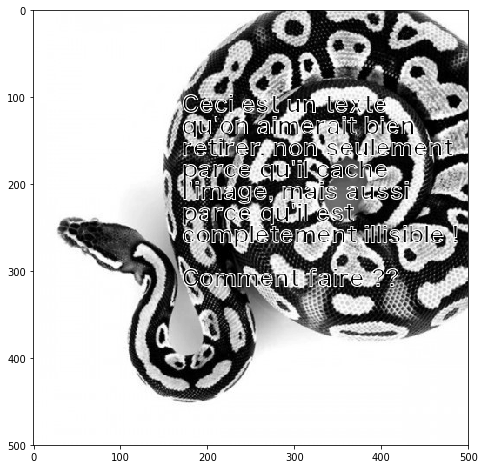

In [4]:
Im = imread('TP6_Image.png')
imshow(Im)

**Exercice** : Quelle est la taille de l'image ? Si chaque pixel représente une variable, combien y a-t-il de variables au total ? Montrer que l'image peut être vu comme un vecteur de taille environ 250000.

**Exercice** : Créer une image aléatoire `Im_alea` de même taille que `Im`, où tous les coefficients sont tirés aléatoirement uniformément entre $0$ et $1$, et afficher cette image.
- On pourra utiliser la fonction `rand`

In [6]:
h,w = shape(Im)
h,w

(500, 500)

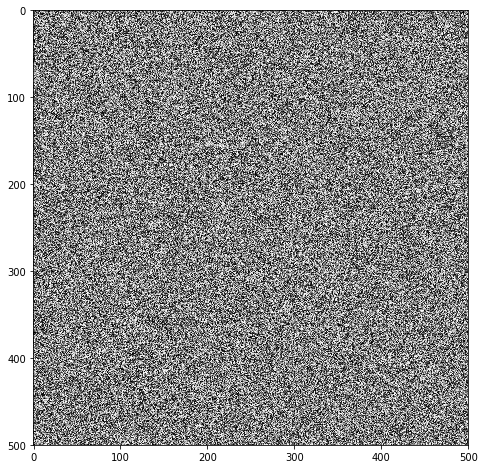

In [8]:
Im_alea=rand(h,w)
imshow(Im_alea)
?roll


## 1. Les dérivées d'une image

Soit $I$ de taille $h \times w$. On appelle *Laplacien de $I$* l'image $\Delta_I$ de taille $h \times w$ telle que
$$
    \left( \Delta_I \right)[i,j] := I[i+1,j] + I[i-1, j] + I[i,j+1] + I[i,j-1] - 4I[i,j]
$$
Ici, on suppose que l'image est *périodique*, dans le sens où tous les indices sont calculés modulo $h$ ou $w$.

**Exercice** : Montrer que $\Delta : I \mapsto \Delta_I$ est un opérateur linéaire de $\mathbb{R}^{h\times w}$ dans $\mathbb{R}^{h\times w}$. Si on représente l'opérateur $\Delta$ par une matrice, de quelle taille serait cette matrice ? Quel est le problème ?

**Exercice** : Ecrire une fonction `Delta(I)` qui prend une image `I` et renvoie `\Delta_I`.
- On pourra utiliser la fonction `roll`

In [25]:
def Delta(I):
    return roll(I,1,1)+roll(I,-1,1)+roll(I,1,0)+roll(I,-1,0)-4*I
#roll(I,1,1) permute de 1 la matrice par rappport aux colonnes (2eme dimension)
#roll(I,1,0) permute de 1 la matrice par rapport aux lignes (1ere dimension)

#Le laplacien permet de prendre la moyenne des pixels autour du pixel concerne 
    

**Exercice** : Afficher le Laplacien de l'image initiale, et le Laplacien de l'image aléatoire. Que se passe-t-il ? Pouvez-vous expliquer ce phénomène ?
- On pourra utiliser la commande `subplot` pour afficher des images côte à côte (cf google)

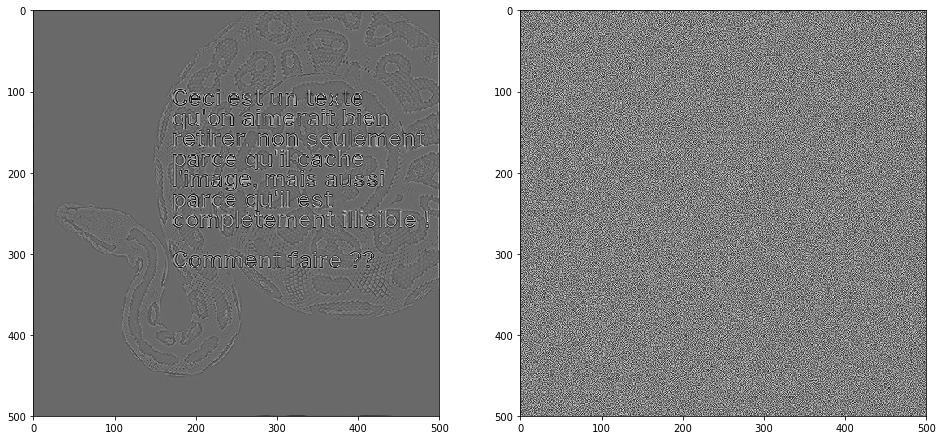

In [26]:
subplot(121)
imshow(Delta(Im))
subplot(122)
imshow(Delta(Im_alea))

#on chope une image uniforme car on prend la moyenne des pixels autour
#or la seule veritable différence est sur les bords des objets (frontiere du serpent et de smots)
#on voit seulement les grandes variations de couleur sur limage

On appelle *énergie $H_1$* de l'image $I$ le nombre réel
$$
    H_1(I) :=  \left[\sum_{i,j} \left( \big| I[i+1,j] - I[i,j] \big|^2 + \big| I[i,j+1] - I[i,j] \big|^2 \right) \right]^{1/2}.
$$

**Exercice (!) **: Montrer que 
$$
    \left[ H_1(I) \right]^2 = - \sum_{i,j} I[i,j] \times \Delta_I[i,j] = - \langle I, \Delta_I \rangle_{\mathbb{R}^{h \times w}}.
$$

**Exercice** : Ecrire une fonction `H1(I)` qui calcule l'énergie $H_1$ de l'image $I$. Calculer `H1(Im)` et `H1(Im_alea)`. Que remarquez-vous ?

In [27]:
def H1(I):
    return sqrt(-sum(I*Delta(I)))

print("H1(Im)=",H1(Im))
print("H1(Im_alea)=",H1(Im_alea))

H1(Im)= 80.54117
H1(Im_alea)= 288.6104453079298


In [28]:
#Vérification, ne pas modifier
assert( abs(H1(Im) - 80.5412) < 1e-3) , "problème dans la fonction H1"

Dans la suite, on fera l'hypothèse que l'énergie $H1$ permet de *détecter les vraies images*. Pour restaurer une image, on cherchera donc à minimiser cette énergie.

** Exercice ** : Quel est le minimum de $H1$ ? Pour quelles images ce minimum est-il atteint ? Pourquoi faut-il imposer des contraintes pour restaurer des images en minimisant $H_1$ ?

## 2. Projection sur la contrainte

Dans la méthode *inpainting*, on sait exactement quelle zone on veut *restaurer*. Cela signifie qu'on sait quels pixels doivent être modifiés, et quels pixels doivent rester constant. Autrement dit, on a accès à un *masque* M.

Dans notre cas par exemple, on voudrait retirer le texte de l'image, et éventuellement les coupures verticales. On utilisera le masque **TP6_Masque.png**.

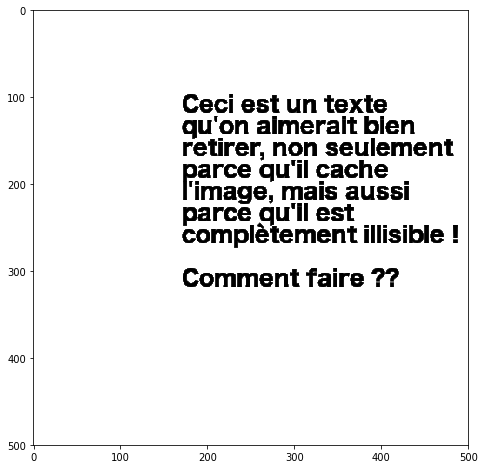

In [29]:
M = imread('TP6_Masque.png')
imshow(M)

On notera que les pixels du masque vérifie $M[i,j] = 1$ (blanc) si le pixel est déjà bien, et vaut $M[i,j] = 0$ s'il doit être modifié (noir).


Soit $I$ une image quelconque. On appelle *projection de I* l'image $P(I)$ telle que
$$
    P(I) [i,j] := \begin{cases} {\rm Im}[i,j] \quad \text{si} \quad M[i,j] = 1 \\
        I[i,j] \quad \text{sinon}.
        \end{cases}  
$$
On notera que la projection dépend de l'image initiale `Im` et du masque `M`. Dans la suite, on note $C = A\odot B$ la matrice telle que $C[i,j] = A[i,j] B[i,j]$.

**Exercice** : Montrer que $P(I) = M \odot Im + (1 - M) \odot I$.

**Exercice** : Ecrire une fonction `P(I)` qui renvoie la projection de l'image $I$, puis afficher `P(Im_alea)`.

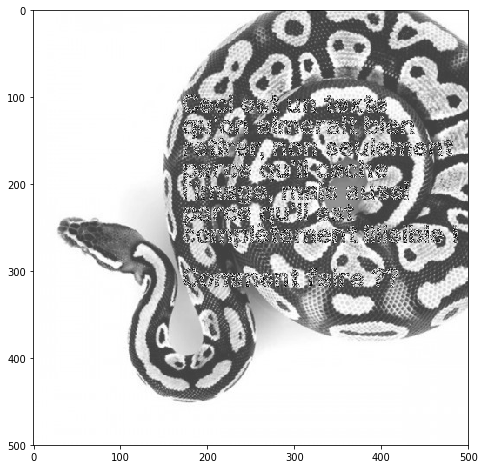

In [31]:
def P(I):
    return M*Im+(1-M)*I   #produit terme a terme donné par le *

imshow(P(Im_alea)) #on a remplacé le spixels par ceux de l'image aléatoire

**Exercice** : Montrer que l'application $I \mapsto P(I)$ est affine de $\mathbb{R}^{h \times w}$ dans $\mathbb{R}^{h \times w}$, puis que $P \circ P = P$ (donc $P$ est bien une projection).

## 3. Méthode du gradient projeté

Dans la méthode du gradient projeté, on veut minimiser $H_1(I)$ sous la contrainte que $I = P(I)$, ce qui équivalent à dire que $I$ est dans l'image de $P$, ou encore les bons pixels de $I$ sont les pixels de `Im`.

L'idée est de faire une descente de gradient à pas constant $\tau$, et de projeter les itérations avec $P$. Autrement dit
$$
    I_{n+1} = P \left( I_n - \tau \nabla H_1(I_n) \right).
$$

Pour faire cela, on commence par calculer le gradient de $H1$. On fera attention qu'en parlant de gradient, on voit ici les images comme des vecteurs de $\mathbb{R}^{h \times w}$, où on juste "trié" les éléments sous forme d'une image.

**Exercice** : Montrer que
$$
    \nabla H_1(I) = \dfrac{- \Delta_I}{\sqrt{- \langle I, \Delta_I \rangle}}.
$$
**Exercice** : Ecrire une fonction `dH1(I)` qui renvoie le gradient de $H_1$ en $I$.

In [32]:
def dH1(I):
    DeltaI=Delta(I)
    return 1/sqrt(-sum(I*DeltaI))*(-DeltaI)
    

**Exercice** : Ecrire une fonction `gradientProjete(dH, I0, tau, tol=1e-4, Niter=200)` qui calcule les itérations du gradient projeté en partant de $I_0$. 
- On pourra s'arrêter lorsque `norm(Inp1 - In) < tol`.

In [37]:
def gradientProjeté(dH,I0,tau,tol=1e-4,Niter=200):
    In=I0
    for n in range (Niter):
        Inp1= P(In-tau*dH(In))
        if norm(Inp1-In)<tol:
            return Inp1
        In=Inp1
    print("L'algorithme n'a pas convergé apres",Niter,"itérations")
    return Inp1

**Exercice** : Tester votre fonction, et afficher le résultat.
- On pourra prendre `tau = 10`.

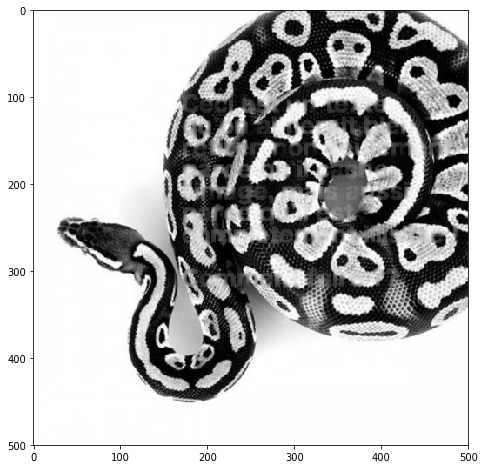

In [38]:
Istar=gradientProjeté(dH1,Im,10)
imshow(Istar)

## 4. Pour aller plus loin, la variation totale

La minimisation de $H_1$ donne déjà des résultats assez convaincants. Cependant, on arrive encore à lire le texte. On cherche maintenant une autre fonctionnelle à minimiser. On peut regarder par exemple la fonctionelle suivante, appelée *variation totale* (total variation)
$$
    TV(I) :=  \sum_{i,j} \sqrt{ \delta + \big| I[i+1,j] - I[i,j] \big|^2 + \big| I[i,j+1] - I[i,j] \big|^2 }.
$$
Notez que la position de la racine carrée a changé. Ici, $\delta > 0$ est un petit paramètre pour dériver la racine.

**Exercice** : Ecrire une fonction `TV(I)` qui renvoie la variation totale de l'image $I$, et calculer la variation totale de l'image initiale et de l'image aléatoire.
- on prendra `delta = 1e-1`.

In [2]:
def TV(I):
    J1=(2*I-roll(I,1,0)-roll(I,1,1))/sqrt(delta+(roll(I,1,0)-I)**2+(roll(I,1,1)-I)**2)
    Im1=roll(I,-1,0)
    J2=(I-Im1)/sqrt(delta +(I-Im1)**2+(roll(Im1,1,1)-Im1)**2)
    Ijm1=roll(I,-1,1)
    J3=(I-Ijm1)/sqrt(delta+(Ijm1-roll(Ijm1,1,0))**2+(I-Ijm1)**2)
    return J1+J2+J3

**Exercice (!) ** : Montrer que le gradient de $TV$ en $I$ et donné par
\begin{align*}
    \dfrac{\partial TV(I)}{\partial I[i,j]} = & 
    \dfrac{2 I[i,j] - I[i+1, j] - I[i, j+1]}{\sqrt{ \delta + \big| I[i+1,j] - I[i,j] \big|^2 + \big| I[i,j+1] - I[i,j] \big|^2 }} \\
    & \quad +
    \dfrac{I[i,j] - I[i-1, j]}{\sqrt{ \delta + \big| I[i,j] - I[i-1,j] \big|^2 + \big| I[i-1,j+1] - I[i-1,j] \big|^2 }} \\
    & \quad + 
    \dfrac{I[i,j] - I[i, j-1]}{\sqrt{ \delta + \big| I[i,j-1] - I[i+1,j-1] \big|^2 + \big| I[i,j] - I[i,j-1] \big|^2 }}.
\end{align*}

**Exercice** : Ecrire une fonction `dTV(I)` qui renvoie ce gradient. 
- On fera attention à ne pas utiliser de boucles !

**Exercice** Afficher les images `dTV(Im)` et `dTV(Im_alea)`. Qu'observez-vous ?

**Exercice** : Afficher côte à côte les images `dTV(I)` et `Delta(I)`. Qu'en pensez-vous ?

** Exercice ** : tester le gradient projeté avec l'énergie TV. Que pensez-vous du résultat ?
- On pourra prendre `tau = 0.1`